# CheckM Output Analysis - Genus Level

## Importing Dependencies

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import ast

## Reading & Converting Data

In [2]:
# File path
file = '../checkm_output_genus_level/storage/bin_stats_ext.tsv'

# Reading the file and parsing the data
df = pd.read_csv(file, sep="\t", header=None)
df.columns = ['Genome', 'Data']
df["Data"] = df["Data"].apply(ast.literal_eval)
gc_df = pd.json_normalize(df["Data"])
df = pd.concat([df["Genome"], gc_df], axis=1)
df = df.convert_dtypes()

# General information about the dataframe
rows, columns = df.shape
print(f"Rows: {rows}, Columns: {columns}")
print(df.head())

Rows: 30, Columns: 34
        Genome      marker lineage  # genomes  # markers  # marker sets    0  \
0  M1011017846  Peptostreptococcus          3        839            240  164   
1  M1169992633  Peptostreptococcus          3        839            240  190   
2  M1313391652  Peptostreptococcus          3        839            240  194   
3  M1248619108  Peptostreptococcus          3        839            240   96   
4  M1327201444  Peptostreptococcus          3        839            240   54   

     1   2  3  4  ...  Mean contig length  Coding density  Translation table  \
0  663  12  0  0  ...          4808.05283        0.884266                 11   
1  638  10  1  0  ...         3902.453988        0.881368                 11   
2  630  15  0  0  ...         3889.719403        0.886333                 11   
3  734   9  0  0  ...         6253.159292        0.883712                 11   
4  770  15  0  0  ...         7295.673171        0.884257                 11   

   # predicted g

## Data Exploration

### Quality & Contamination of the MAGs

In [3]:
# Obtaining high, medium, and low quality genomes based on Completeness and Contamination
high_quality = df[(df['Completeness'] >= 90) & (df['Contamination'] < 5)]
medium_quality = df[(df['Completeness'] >= 50) & (df['Completeness'] <= 90) & (df['Contamination'] < 5)]
low_quality = df[(df['Completeness'] < 50) | (df['Contamination'] >= 5)]

print("High Quality:", len(high_quality))
print("Medium Quality:", len(medium_quality))
print("Low Quality:", len(low_quality))

High Quality: 15
Medium Quality: 15
Low Quality: 0


In [4]:
# Saving the filtered dataframes to CSV files
high_quality.to_csv("high_quality_genomes.csv", index=False)
medium_quality.to_csv("medium_quality_genomes.csv", index=False)

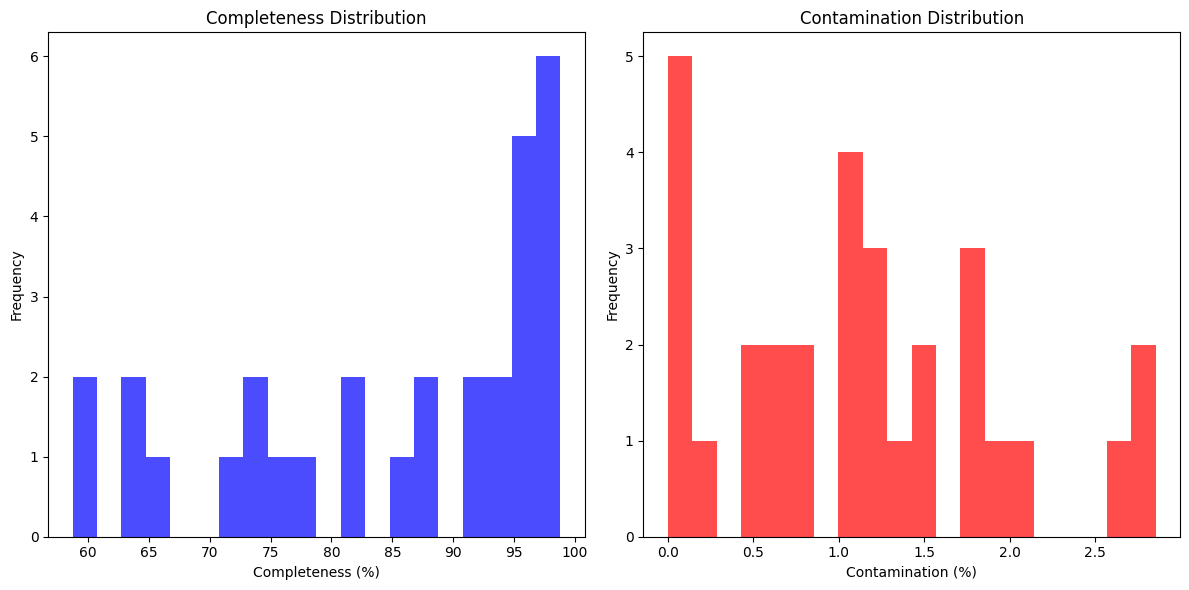

In [5]:
# Getting the distribution of Completeness and Contamination
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['Completeness'], bins=20, color='blue', alpha=0.7)
plt.title('Completeness Distribution')
plt.xlabel('Completeness (%)')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(df['Contamination'], bins=20, color='red', alpha=0.7)
plt.title('Contamination Distribution')
plt.xlabel('Contamination (%)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("completeness_contamination_distribution.png")
plt.show()

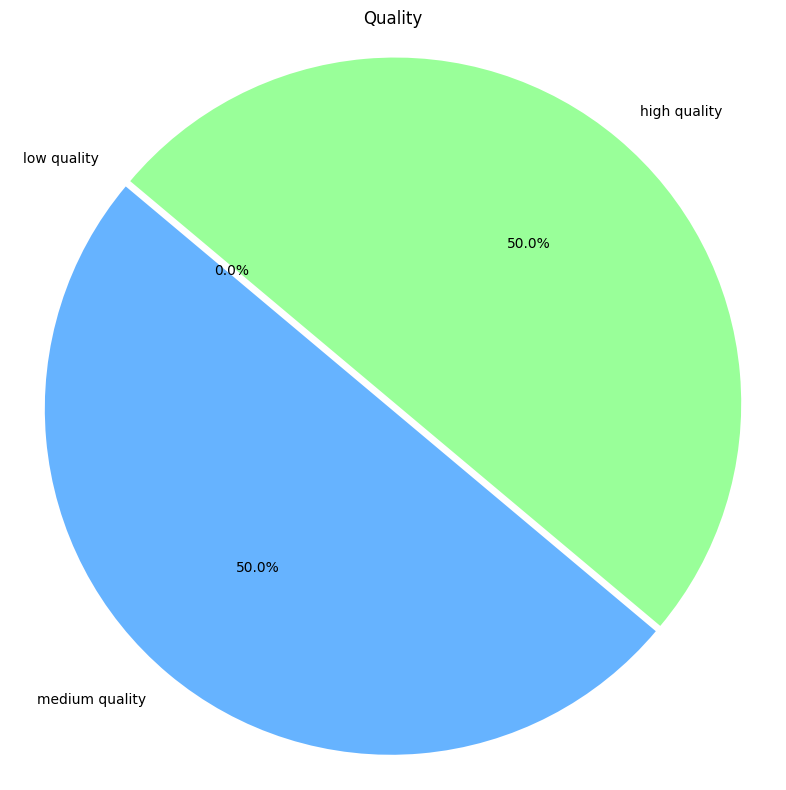

In [6]:
# Creating a pie chart for quality levels
quality_dict = {
        'low quality' : len(low_quality),
        'medium quality' : len(medium_quality),
        'high quality' : len(high_quality)
}

labels = quality_dict.keys()
sizes = quality_dict.values()
colors = ['#ff9999', '#66b3ff', '#99ff99']
explode = (0.01, 0.01, 0.01)

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
plt.title("Quality")
plt.axis('equal')
plt.tight_layout()
plt.savefig("quality_levels_pie_chart.png")
plt.show()

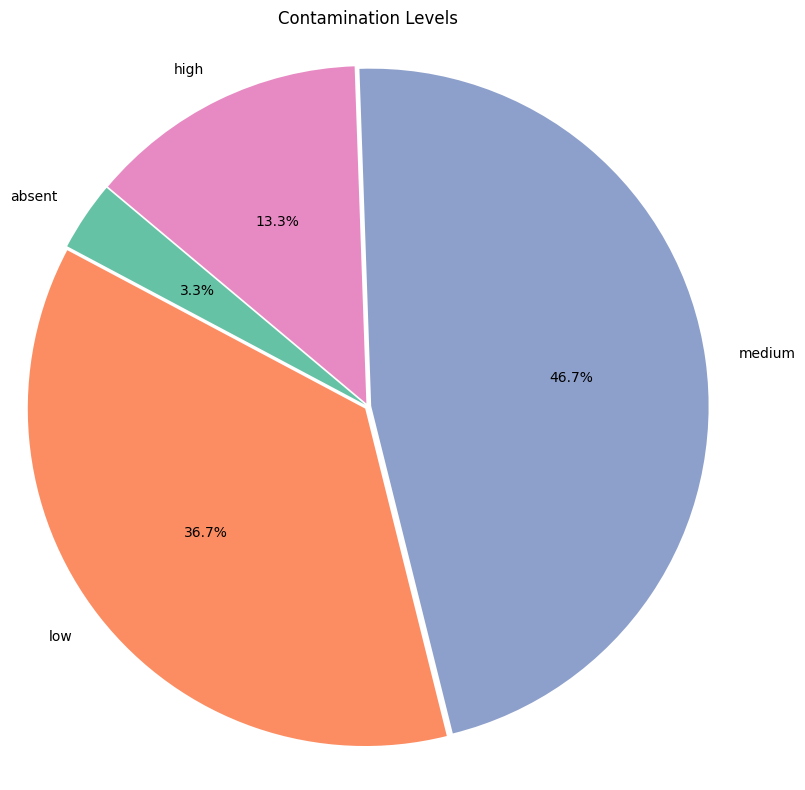

In [7]:
# Creating a pie chart for contamination levels
contamination_dict = {
        'absent' : len(df[df['Contamination'] == 0]),
        'low' : len(df[(df['Contamination'] < 1) & (df['Contamination'] != 0)]),
        'medium' : len(df[(df['Contamination'] >= 1) & (df['Contamination'] < 2)]),
        'high' : len(df[(df['Contamination'] >= 2) & (df['Contamination'] < 5)])
}

labels = contamination_dict.keys()
sizes = contamination_dict.values()   
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
explode = (0.01, 0.01, 0.01, 0.01)

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
plt.title("Contamination Levels")
plt.axis('equal')
plt.tight_layout()
plt.savefig("contamination_levels_pie_chart.png")
plt.show()

In [8]:
# Creating a copy of the dataframe
df_copy = df.copy()

# Defining quality categories
def get_quality(row):
    if row['Completeness'] >= 90 and row['Contamination'] < 5:
        return "High Quality"
    elif row['Completeness'] >= 50 and row['Contamination'] < 5:
        return "Medium Quality"
    else:
        return "Low Quality"

# Defining contamination level bins
def get_contamination(row):
    if row['Contamination'] == 0:
        return "No Contamination"
    elif row['Contamination'] < 1:
        return "Low Contamination (<1%)"
    elif row['Contamination'] < 2:
        return "Medium Contamination (1–2%)"
    else:
        return "High Contamination (2–5%)"

# Applying categorization
df_copy["Quality"] = df_copy.apply(get_quality, axis=1)
df_copy["ContamLevel"] = df_copy.apply(get_contamination, axis=1)

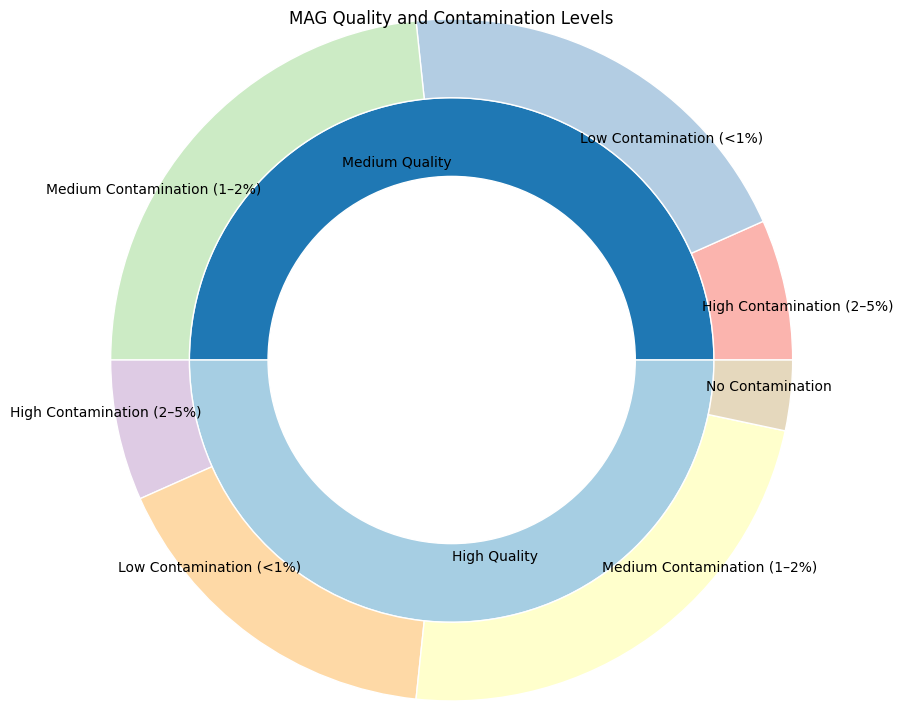

In [9]:
# Outer pie: contamination levels per quality level
outer_counts = df_copy.groupby(["Quality", "ContamLevel"]).size().reset_index(name="count")
outer_labels = outer_counts.apply(lambda x: f"{x['ContamLevel']}", axis=1)
outer_sizes = outer_counts["count"].tolist()

# Inner pie: overall quality categories
inner_counts = df_copy["Quality"].value_counts()
inner_labels = inner_counts.index.tolist()
inner_sizes = inner_counts.tolist()

# Define colors
color_map = {
    "High Quality": '#a6cee3',
    "Medium Quality": '#1f78b4',
    "Low Quality": '#b2df8a'
}
inner_colors = [color_map[label] for label in inner_labels]
outer_colors = plt.cm.Pastel1.colors * 3  # Repeat to ensure enough

# Plotting
fig, ax = plt.subplots(figsize=(9, 9))

# Inner ring
ax.pie(inner_sizes, radius=1, labels=inner_labels, colors=inner_colors,
       wedgeprops=dict(width=0.3, edgecolor='white'), labeldistance=0.75)

# Outer ring
ax.pie(outer_sizes, radius=1.3, labels=outer_labels, colors=outer_colors,
       labeldistance=0.75, wedgeprops=dict(width=0.3, edgecolor='white'))

# Final layout
ax.set(aspect="equal")
plt.title("MAG Quality and Contamination Levels")
plt.tight_layout()
plt.savefig("quality_contamination_pie_chart.png")
plt.show()

### GC Content of the MAGs

In [4]:
# Calculating and printing statistics of GC content
mean_gc = df["GC"].mean()
median_gc = df["GC"].median()
min_gc = df["GC"].min()
max_gc = df["GC"].max()
high_quality_count = df[(df["Completeness"] >= 90) & (df["Contamination"] < 5)].shape[0]

print(f"Mean GC content: {mean_gc:.4f}")
print(f"Median GC content: {median_gc:.4f}")
print(f"Minimum GC content: {min_gc:.4f}")
print(f"Maximum GC content: {max_gc:.4f}")
print(f"High-quality MAGs: {high_quality_count}") 

Mean GC content: 0.3731
Median GC content: 0.3727
Minimum GC content: 0.3643
Maximum GC content: 0.3836
High-quality MAGs: 15


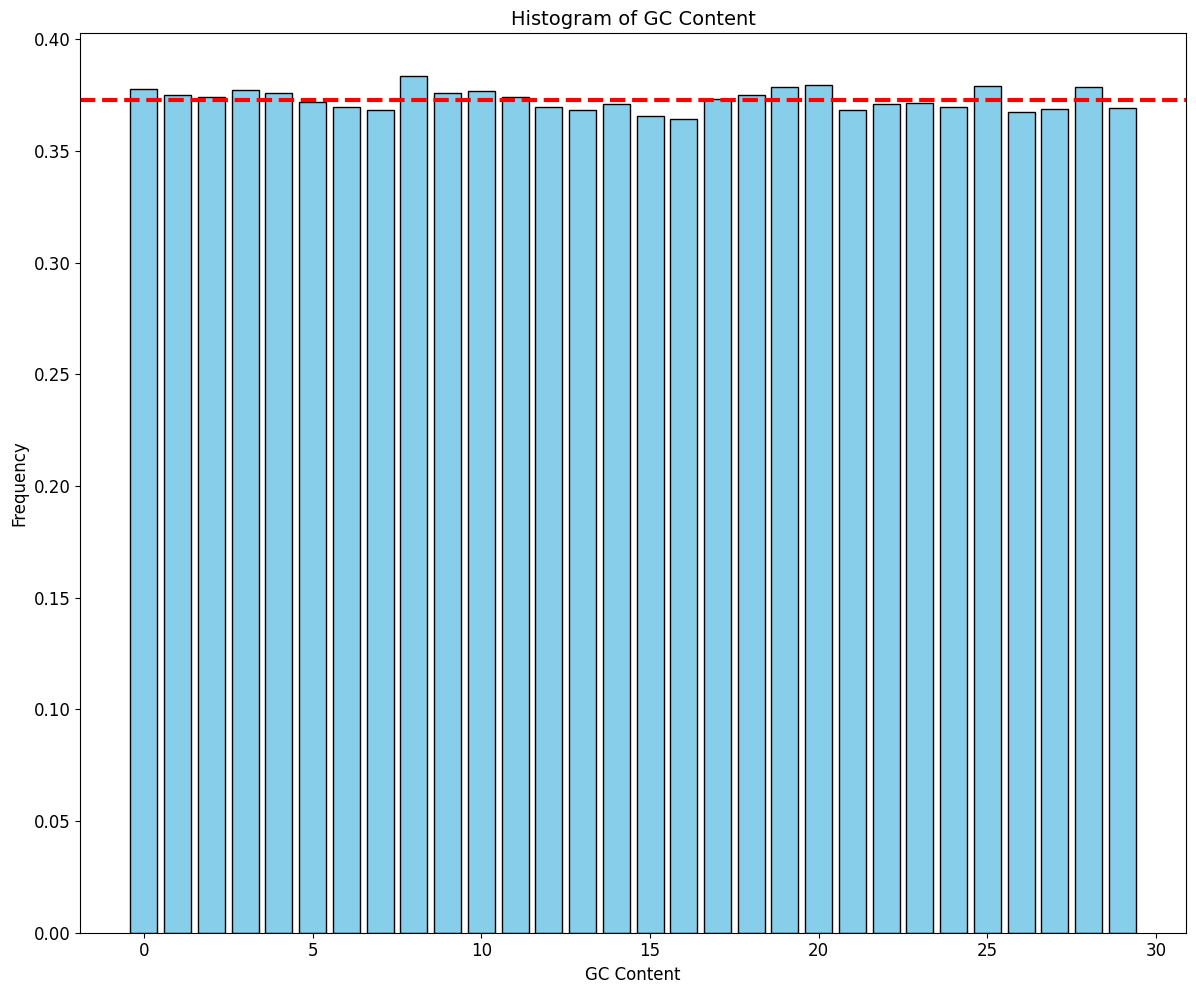

In [5]:
# Plotting histogram of GC content for all MAGs
plt.figure(figsize=(12, 10))
plt.bar(range(len(df['GC'])), df['GC'], color='skyblue', edgecolor='black')
plt.title('Histogram of GC Content', fontsize=14)
plt.xlabel('GC Content', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axhline(y=mean_gc, color='red', linestyle='dashed', linewidth=3)
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("gc_content_histogram.png")
plt.show()

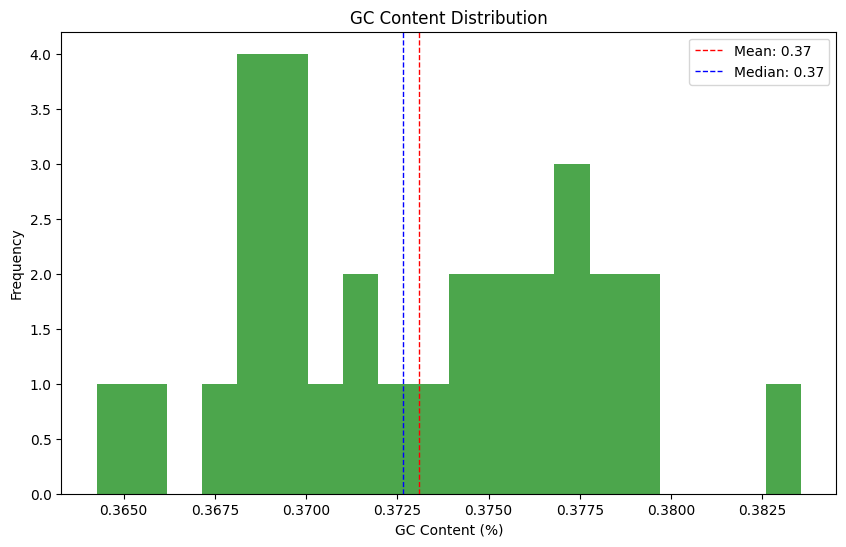

In [12]:
# Plotting histogram of GC content with mean and median lines
plt.figure(figsize=(10, 6))
plt.hist(df["GC"], bins=20, color='green', alpha=0.7)
plt.title('GC Content Distribution')
plt.xlabel('GC Content (%)')
plt.ylabel('Frequency')
plt.axvline(mean_gc, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_gc:.2f}')
plt.axvline(median_gc, color='blue', linestyle='dashed', linewidth=1, label=f'Median: {median_gc:.2f}')
plt.legend()
plt.savefig("gc_content_distribution.png")
plt.show()

### Completeness vs Genome Size

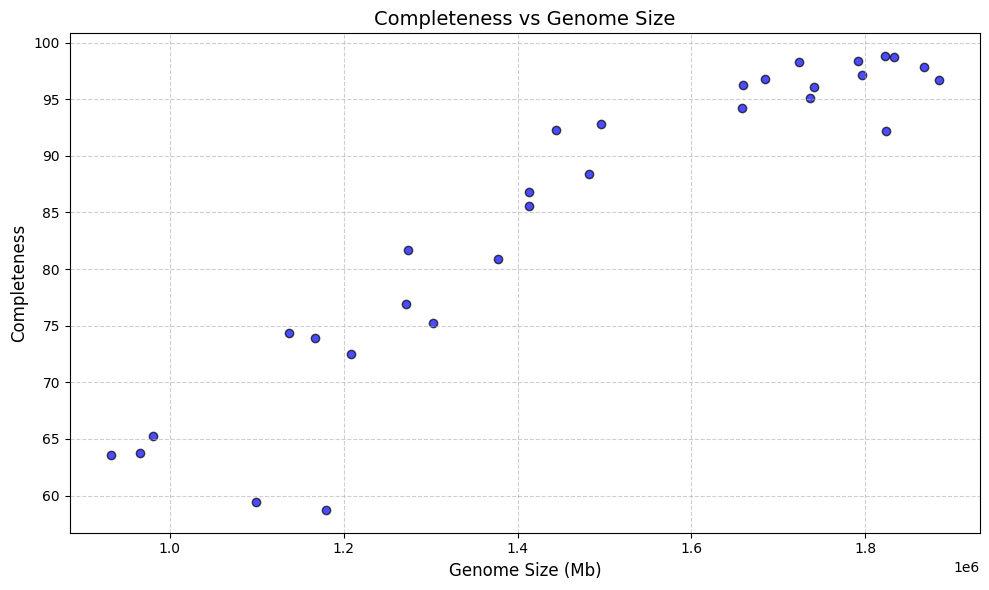

In [13]:
# Plotting scatter plot of Completeness vs Genome Size
plt.figure(figsize=(10, 6))
plt.scatter(df['Genome size'], df['Completeness'], color='blue', alpha=0.7, edgecolor='black')
plt.title('Completeness vs Genome Size', fontsize=14)
plt.xlabel('Genome Size (Mb)', fontsize=12)
plt.ylabel('Completeness', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("completeness_vs_genome_size.png")
plt.show()

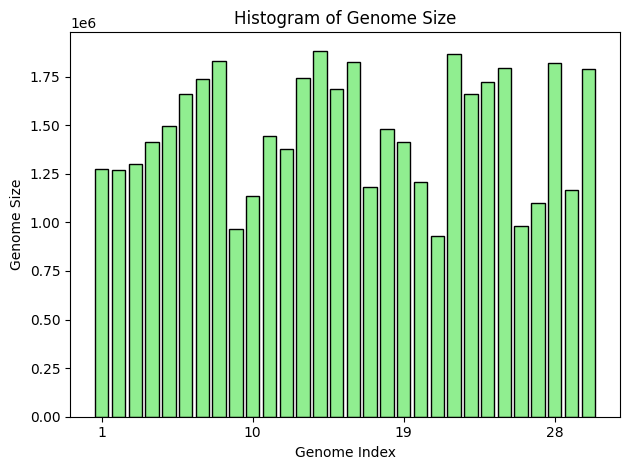

In [14]:
# Plotting histogram of genome size
plt.bar(range(1, len(df['Genome size']) + 1), df['Genome size'], color='lightgreen', edgecolor='black')
plt.title('Histogram of Genome Size')
plt.xlabel('Genome Index')
plt.ylabel('Genome Size')
plt.xticks(range(1, len(df['Genome size']) + 1, 9))  # Set x-axis ticks to start from 1
plt.tight_layout()
plt.savefig("genome_size_histogram.png")
plt.show()